# Basics of Scipy's rotation submodule

> **Goal**: Briefly explain all common ways of representing a rotation in 3D Cartesian space and how they work using Scipy's Rotation submodule. The purpose of using Scipy and not a specific library (e.g. https://dfki-ric.github.io/pytransform3d/) is to keep dependencies to a minimum (Scipy is also used for minimisation).

Scipy's rotation module provides the following ways of representing a 3D rotation

- Rotation Matrices
- Euler Angles
- Quaternions
- Rotation Vectors (a concise three-number representation of Euler axis-angle pair)
- Modified Rodrigues Parameters (a.k.a. Log map or logarithm of rotation)

as well as different operations on rotations and transformations between them. It is important to keep in mind that **all representations** are somewhat redundant or discontinuous or with singularities (although not all to the same degree). Below is a table summarising their properties:

|          **Representation**          |  **Inverse**  | **Rotation of vector** | **Concatenation** | **Interpolation** | **Scipy name** |
| :----------------------------------: | :-----------: | :--------------------: | :---------------: | :---------------: | :------------: |
|         Rotation matrix $R$          |   Transpose   |          Yes           |        Yes        |        No         |     matrix     |
| Euler angles ($\alpha,\beta,\gamma$) |      No       |           No           |        No         |        No         |     euler      |
|           Quaternion ($q$)           |   Conjugate   |          Yes           |        Yes        |        Yes        |      quat      |
|      Rotation vector ($\omega$)      | Negative axis |           No           |        No         |        Yes        |     rotvec     |
|    Rodrigues parameters ($\omega$)   |    Negative   |           No           |        No         |       (Yes)       |      mrp       |


For more details see:  
https://dfki-ric.github.io/pytransform3d/rotations.html (most of the info here is based on the documentation of this Python module)  
https://en.wikipedia.org/wiki/Rotation_formalisms_in_three_dimensions

## Examples of representation of rotations and transformations between them

In [1]:
# imports needed
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as r
import ftir_funct as f

module FTIR v.2024.3.12 imported


After importing _Rotation as r_ from _scipy.spatial.transform_, rotations are defined as follows:  

``r.from_<representation>(parameters)``  

where the representation of the rotation can be of any type defined in the table (Scipy name) and the input parameters will depend on the type of representation. For example:

In [2]:
# define a rotation using Euler angles (Bunge convention)
rotation = r.from_euler('zxz', [30, 45, 40], degrees=True)

The transformations between the different types of representation of rotations is done as follows: 

``r.as_<representation>(parameters)``  

for example:

In [3]:
# represent the rotation into a quaternion
rotation.as_quat()

array([0.38122721, 0.03335306, 0.52991553, 0.75679781])

Below I show a few more transformation examples in a formated way using f-strings

In [4]:
print(f"Euler angles:     {np.around(rotation.as_euler('zxz', degrees=True), decimals=1)} (Bunge convention)")
print(f"Euler angles:     {np.around(rotation.as_euler('zxy', degrees=True), decimals=1)} ('zxy' convention)")
print(f"Quaternions:      {np.around(rotation.as_quat(), decimals=3)}")
print(f"Rotation vectors: {np.around(rotation.as_rotvec(degrees=True), decimals=2)}")
print(f"Mod. Rod. Params: {np.around(rotation.as_mrp(), decimals=3)}")
print(f"Rotation matrix: \n {np.around(rotation.as_matrix(), decimals=3)}")

Euler angles:     [30. 45. 40.] (Bunge convention)
Euler angles:     [79.9 32.8 32.7] ('zxy' convention)
Quaternions:      [0.381 0.033 0.53  0.757]
Rotation vectors: [47.61  4.17 66.18]
Mod. Rod. Params: [0.217 0.019 0.302]
Rotation matrix: 
 [[ 0.436 -0.777  0.455]
 [ 0.828  0.148 -0.542]
 [ 0.354  0.612  0.707]]


Note that all the outputs are numpy ndarrays.

## Examples of operations

Apply rotation(s) to a set of vectors  
``r.apply()``  

Invert a rotation  
``r.inv()``  

Get the magnitude(s) of the rotation(s) (angle in radians)  
``r.magnitude()``  

Get the mean of the rotations  
``r.mean()``

Generate uniformly distributed rotations  
``r.random()``  

TODO

## A brief note on the representations we are going to use

Crystalline orientation data is usually stored using **Euler angles** (e.g. the EBSD community) as these provide a compact way (three numbers) of representing an full 3D orientation respect to a reference frame through a rotation. On the other hand, the **rotation matrix** is typically used for most operations. These two are the representations we will use most often.

### Euler angles (Bunge convention)

Any orientation can be expressed as three rotations around basis vectors. However, the definition of Euler angles is not unique and the order in which we concatenate rotation matters. This means that there are 12 different ways to sequence the rotations and these can be interpreted as extrinsic (relative to an external fixed coordinate system) or intrinsic (body/crystal-fixed coordinates) rotations resulting in 24 different conventions. Other disadvantages of using Euler angles for the representation of rotations (and orientations) are (1) rotation angles can be defined in radians or degrees, (2) the gimbal lock singularity, or that (3) it requires conversion to other representaions (e.g. rotation matrix or quaternions) to concatenate or interpolation operations.

In the EBSD community typically uses the Bunge convention, where the the sequence of rotations is $z$, $y$, $z$. Since our aim is to orientate crystals with respect to a fixed external reference frame (i.e. the sample), we are concerned with **extrinsic rotations** and the angles are usually given/stored in degrees. All of these constraints can be easily specified in the rotation module. For example, the sequence of axes for rotations uses a string with 3 characters (either x, y or z) using capitals for intrinsic rotations (e.g. ``'XYZ'``) and lower case for extrinsic rotations (e.g. ``'xyz'``), so that in an definition like teh one used above

```python
r.from_euler('zxz', [30, 45, 40], degrees=True)
```
- The first parameter, ``'zxz'``, means that the sequence of rotations is $z$, $y$, $z$ (as in Bunge) and that the rotation is extrinsic (lower case letters)
- The second parameter, ``[30, 45, 40]``, is the Euler angles as a Python list
- The third parameter indicates that the Euler angles are provided in degrees (if not provided, it assumes radians)

TODO  

### Rotation matrix

The rotation matrix is a representation of an rotation/orientation defining by 9 values. In our case it is represented by a numpy array of shape (3, 3).

$$\begin{aligned}
\boldsymbol R =
\left( \begin{array}{ccc}
    r_{11} & r_{12} & r_{13}\\
    r_{21} & r_{22} & r_{23}\\
    r_{31} & r_{32} & r_{33}\\
\end{array} \right)
\end{aligned}$$

It is one of the most practical representations of a rotation in a 3D Cartesian space because is easy to apply rotations or concatenate rotations on point vectors by matrix-vector multiplication. Also, you can directly read the basis vectors from the columns and has no singularities. The downsides are that  ias a non-minimal representation (9 terms)...TODO

### Example of ploting an orientation using the crystal axis

Modified from https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html#scipy.spatial.transform.Rotation



In [5]:
# create three rotations/orientations
r0 = r.identity()
r1 = r.from_euler("ZYX", [90, -30, 0], degrees=True)  # intrinsic
r2 = r.from_euler("zyx", [90, -30, 0], degrees=True)  # extrinsic

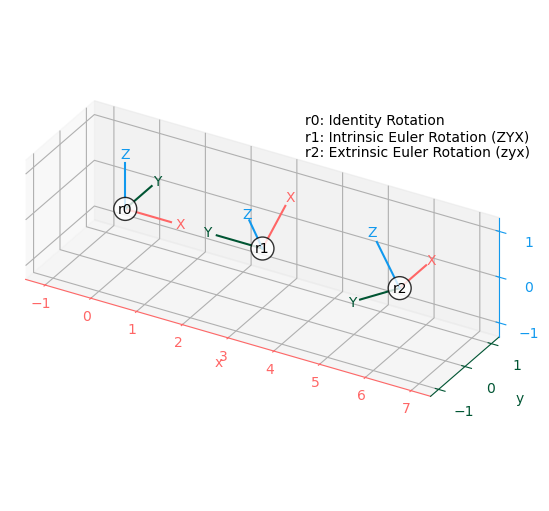

In [6]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(6, 5), constrained_layout=True)

# Set the orthographic projection: https://matplotlib.org/stable/gallery/mplot3d/projections.html
ax.set_proj_type('ortho')  # FOV = 0 deg

f.plot_crystal_axes(ax, r0, name='r0', offset=(0, 0, 0))
f.plot_crystal_axes(ax, r1, name='r1', offset=(3, 0, 0))
f.plot_crystal_axes(ax, r2, name='r2', offset=(6, 0, 0))

_ = ax.annotate(
    'r0: Identity Rotation\n'
    'r1: Intrinsic Euler Rotation (ZYX)\n'
    'r2: Extrinsic Euler Rotation (zyx)',
    xy=(0.6, 0.7), xycoords='axes fraction', ha='left'
)

ax.set(xlim=(-1.25, 7.25), ylim=(-1.25, 1.25), zlim=(-1.25, 1.25))
ax.set(xticks=range(-1, 8), yticks=[-1, 0, 1], zticks=[-1, 0, 1])
ax.set_aspect('equal', adjustable='box')

In [7]:
import sys
import scipy as sp
import matplotlib as mpl
from datetime import date    
today = date.today().isoformat()

print(f'Notebook tested in {today} using:')
print('Python', sys.version)
print('Numpy', np.__version__)
print('Scipy', sp.__version__)
print('Matplolib', mpl.__version__)

Notebook tested in 2024-03-12 using:
Python 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]
Numpy 1.26.4
Scipy 1.11.4
Matplolib 3.8.0
